In [ ]:
#!pip install torch==2.2.2 torchtext==0.17.2 numpy==1.26.4

In [1]:
import torch, torchtext

In [ ]:
%%capture
#!pip install demoji



import re
import demoji
import random
import inflect
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt



import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.functional import one_hot
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import TensorDataset, DataLoader, random_split

In [ ]:
file_path = 'data/human_chat.txt'
with open(file_path, 'r') as file:
  lines = file.readlines()

In [12]:
lines

['Human 1: Hi!\n',
 'Human 2: What is your favorite holiday?\n',
 'Human 1: one where I get to meet lots of different people.\n',
 'Human 2: What was the most number of people you have ever met during a holiday?\n',
 'Human 1: Hard to keep a count. Maybe 25.\n',
 'Human 2: Which holiday was that?\n',
 'Human 1: I think it was Australia\n',
 'Human 2: Do you still talk to the people you met?\n',
 "Human 1: Not really. The interactions are usually short-lived but it's fascinating to learn where people are coming from and what matters to them\n",
 'Human 2: Yea, me too. I feel like God often puts strangers in front of you, and gives you an opportunity to connect with them in that moment in deeply meaningful ways. Do you ever feel like you know things about strangers without them telling you?\n',
 'Human 1: what do you mean?\n',
 'Human 2: I think it\'s like a 6th sense, often seen as "cold readings" to people, but can be remarkably accurate. I once sat next to a man in a coffee and I felt

In [13]:
len(lines)

1495

In [14]:
def preprocess_text(text):
  #Remove HTML tags
  soup = BeautifulSoup(text, 'html.parser')
  text = soup.get_text()

  p = inflect.engine()
  demoji.download_codes()
  #Remove emojis
  text = demoji.replace(text, "")

  #Remove mentions of "Human1", and "Human 2"
  text = re.sub(r'\b(?:Human 1|Human 2)\b:?', " ", text)

  #Replace numbers with words
  text = re.sub(r'\b\d+\b', lambda x: p.number_to_words(x.group()), text)

  #Remove special character, keeping only alphabetic and spaces
  text = re.sub('[^a-zA-Z\s]', ' ', text)

  #Replace specific unicode spaces with standard spaces and trim
  text = text.replace(u'\xa0', u' ').replace('\u200a', ' ').strip()

  return text

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-207137901.py:18: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('[^a-zA-Z\s]', ' ', text)


In [15]:
preprocessed_lines = [preprocess_text(line) for line in lines]

/tmp/ipython-input-207137901.py:7: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [16]:
preprocessed_lines[0:5]

['Hi',
 'What is your favorite holiday',
 'one where I get to meet lots of different people',
 'What was the most number of people you have ever met during a holiday',
 'Hard to keep a count  Maybe twenty five']

# Torchtext
Torchtext is a library within the PyTorch ecosystem designed to facilitate the preprocessing of textual data.

## get_tokenizer
. The get_tokenizer function is one of the core utilities provided by torchtext for tokenizing text data.

. get_tokenizer retrieves a tokenizer function based on the method specified. This tokenizer can then be used to convert strings of text into lists of tokens.
##Parameters
  
  tokenizer: This argument specifies the type of tokenizer to use. You can specify built-in tokenizers such as "basic_english", "spacy", "moses", or even provide a custom tokenizer function.

  language: Some tokenizers, like those based on the Moses or Spacy libraries, might require you to specify the language of the text, which influences how the text is tokenized (e.g., handling language-specific punctuation and splitting rules).

In [17]:
import torchtext

In [18]:
from torchtext.data.utils import get_tokenizer

In [19]:
tokenizer = get_tokenizer('basic_english')
tokenized_conv = [tokenizer(conv) for conv in preprocessed_lines]

## build_vocab_from_iterator
`build_vocab_from_iterator` function in the torchtext.vocab module is used to create a vocabulary from an iterable of tokenized data. This vocabulary is essential for converting textual data into numerical form.

#Parameters:
##tokenized_conv (iterator):
This is the main data input to the function. It should be an iterator (like a `generator` or a `list`) that yields sequences of tokens. Each sequence represents a document or an example in your dataset.
##min_freq (int, optional):
 This parameter specifies the minimum frequency a token must have to be included in the vocabulary. Tokens that appear fewer than min_freq times are excluded from the vocabulary. This is useful for removing rare words which might be typos or irrelevant to most analyses.
##specials (list of str, optional):
 This is a list of special tokens that you want to add to the vocabulary. Common special tokens include:
'<pad>': A padding token used to equalize the lengths of sequences.
'<oov>' (or '<unk>' for "unknown"): A token used to represent out-of-vocabulary words during inference, or when a word appears that is not in the training vocabulary.
##special_first (bool, optional):
 Determines the ordering of special tokens in the vocabulary. If True, special tokens are added at the beginning of the vocabulary. This can be helpful for certain models where token indices are significant (e.g., models using embedding layers might have specific handling for lower indices).

In [20]:
features_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_conv,
    min_freq=1,
    specials = ['<pad>', '<oov>'],
    special_first = True
)

target_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_conv,
    min_freq = 1
)

In [21]:
features_vocab_total_words = len(features_vocab)
target_vocab_total_words = len(target_vocab)

In [22]:
print('Feature Vocab Length', features_vocab_total_words)
print('Target Vocab Length', target_vocab_total_words)

Feature Vocab Length 2749
Target Vocab Length 2747


In [23]:
#making ngrams from the conversations
def make_ngrams(tokenized_text):
  list_ngrams = []
  for i in range(1, len(tokenized_text)):
    ngram_sequence = tokenized_text[:i+1]
    list_ngrams.append(ngram_sequence)
  return list_ngrams

In [24]:
ngram_list = []
for tokenized_con in tokenized_conv:
  ngram_list.extend(make_ngrams(tokenized_con))

In [25]:
#Add Random oov tokens to let the model handle oov tokens
def add_random_oov_tokens(ngram):
  for idx, word in enumerate(ngram[:-1]):
    if random.uniform(0,1) < 0.1:
      ngram[idx] = '<oov>'

  return ngram

In [26]:
ngram_list_oov = []
for ngram in ngram_list:
  ngram_list_oov.append(add_random_oov_tokens(ngram))

print(any('<oov>' in ngram for ngram in ngram_list_oov))

True


`get_itos`: stands for "index-to-string". The method returns a list where the indices in the list correspond to the numerical indices used in your model, and the values at those indices are the actual string representations (tokens).

In [27]:
def text_to_numerical_sequence(tokenized_text):
  token_list = []
  # Check if tokenized_text is not empty
  if tokenized_text:
    for token in tokenized_text[:-1]:
      num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>']
      token_list.append(num_token)

    # Handle the last token separately for the target vocabulary
    last_token = tokenized_text[-1]
    num_token = target_vocab[last_token] if last_token in target_vocab.get_itos() else target_vocab['<oov>'] # Assuming target_vocab also has an <oov> token, adjust if needed
    token_list.append(num_token)
    return token_list
  return [] # Return an empty list for empty input

In [28]:
input_sequences = [text_to_numerical_sequence(sequence) for sequence in ngram_list_oov if text_to_numerical_sequence(sequence)]

In [29]:
print(f'Total input sequences: {len(input_sequences)}')
print(input_sequences[7:9])

Total input sequences: 18562
[[56, 90, 2, 73, 2], [56, 90, 1, 73, 4, 228]]


In [30]:
from typing import Sequence
X = [sequence[:-1] for sequence in input_sequences]
y = [sequence[-1] for sequence in input_sequences]
len(X[0]), y[0]

(1, 11)

In [31]:
print(X[3], y[3])

[12, 13, 29, 120] 312


In [32]:
longest_sequence_feature = max(len(sequence) for sequence in X)
longest_sequence_feature

153

`F.pad` function is a utility function which is part of torch.nn.functional module,used for padding tensors.
# Parameters:
##input (torch.tensor):
The tensor to be padded.
##pad (tuple of ints):
The number of values padded to the edges of each dimension. The tuple should contain pairs where each pair is the number of values added to the left and right of the dimension, respectively.
##value (scalar, optional):
The constant value used for constant padding. If the mode is 'constant' but no value is specified, it defaults to 0.

In [2]:
import torch

In [34]:
padded_X = [F.pad(torch.tensor(sequence), (longest_sequence_feature-len(sequence), 0), value=0) for sequence in X]
padded_X[1], X[2], len(padded_X[1])

(tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0, 12, 13]),
 [1, 1, 29],
 153)

In [35]:
padded_X = torch.stack(padded_X)
y = torch.tensor(y)
type(y), type(padded_X)

(torch.Tensor, torch.Tensor)

In [36]:
y_one_hot = one_hot(y, num_classes=target_vocab_total_words)

# TensorDataset
`TensorDataset` is a subclass of `Dataset` that is specifically designed to handle scenarios where all data are already in the form of tensors. It wraps tensors, allowing you to access slices of these tensors as individual samples.

 It's particularly useful when your entire dataset is small enough to fit into memory, and you have pre-processed all of your input and target data into tensors. It simplifies the data loading during training when using a DataLoader since all data is already in tensor form and does not require further transformation or loading steps during the batch generation.

In [37]:
data = TensorDataset(padded_X, y_one_hot)

In [38]:
train_size = int(0.8*len(data))
test_size = len(data) - train_size
batch_size = 32

In [39]:
train_data, test_data = random_split(data, [train_size, test_size])

In [40]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [41]:
class My_BiLSTM(nn.Module):
  def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
    super(My_BiLSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
    self.dropout = nn.Dropout(0.3)
    self.fc = nn.Linear(hidden_dim * 2, target_vocab_total_words)

  def forward(self, x):
    x = x.to(self.embedding.weight.device)
    embedded = self.embedding(x)
    lstm_out, _ = self.lstm(embedded)
    lstm_out = self.dropout(lstm_out)
    output = self.fc(torch.cat((lstm_out[:, -1, :hidden_dim], lstm_out[:, 0, hidden_dim:]), dim=1))
    return output

In [42]:
features_vocab_total_words

2749

In [43]:
target_vocab_total_words

2747

In [44]:
embedding_dim=128
hidden_dim = 200
epochs=75

In [45]:
model = My_BiLSTM(features_vocab_total_words, target_vocab_total_words, embedding_dim=embedding_dim, hidden_dim=hidden_dim)

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0009)

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [48]:
model.to(device)

My_BiLSTM(
  (embedding): Embedding(2749, 128)
  (lstm): LSTM(128, 200, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=400, out_features=2747, bias=True)
)

In [49]:
def calculate_topk_accuracy(model, data_loader, k=3):
  model.eval()
  correct_predictions = 0
  total_predictions = 0

  with torch.no_grad():
    for batch_x, batch_y in data_loader:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)

      #Forward pass
      output = model(batch_x)

      #Get top-k predictions
      _, predicted_indices = output.topk(k, dim=1)

      #Check if the correct label is in the top-k predictions
      correct_predictions += torch.any(predicted_indices == torch.argmax(batch_y, dim=1, keepdim=True), dim=1).sum().item()
      total_predictions += batch_y.size(0)

  accuracy = correct_predictions/total_predictions
  return accuracy

In [50]:
all_accuracies = []
all_losses=[]

for epoch in range(epochs):
  model.train()
  for batch_X, batch_y in train_loader:
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    optimizer.zero_grad()
    outputs = model(batch_X)
    loss = criterion(outputs, batch_y.argmax(dim=1))
    loss.backward()
    optimizer.step()

  if epoch % 5 ==0:
    accuracy = calculate_topk_accuracy(model, train_loader)
    print(f'Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Train K-Accuracy: {accuracy*100:.2f}%')
    all_accuracies.append(accuracy)
    all_losses.append(loss.item())

Epoch 0/75, Loss: 10.1933, Train K-Accuracy: 21.33%
Epoch 5/75, Loss: 2.3672, Train K-Accuracy: 62.89%
Epoch 10/75, Loss: 5.7886, Train K-Accuracy: 89.24%
Epoch 15/75, Loss: 0.2057, Train K-Accuracy: 94.73%
Epoch 20/75, Loss: 0.6221, Train K-Accuracy: 95.67%
Epoch 25/75, Loss: 0.8166, Train K-Accuracy: 95.93%
Epoch 30/75, Loss: 0.0020, Train K-Accuracy: 96.05%
Epoch 35/75, Loss: 0.0898, Train K-Accuracy: 96.11%
Epoch 40/75, Loss: 0.0074, Train K-Accuracy: 96.06%
Epoch 45/75, Loss: 0.0025, Train K-Accuracy: 96.07%
Epoch 50/75, Loss: 0.0443, Train K-Accuracy: 96.09%
Epoch 55/75, Loss: 0.0127, Train K-Accuracy: 96.13%
Epoch 60/75, Loss: 0.0000, Train K-Accuracy: 96.06%
Epoch 65/75, Loss: 0.0429, Train K-Accuracy: 96.13%
Epoch 70/75, Loss: 0.0018, Train K-Accuracy: 96.07%


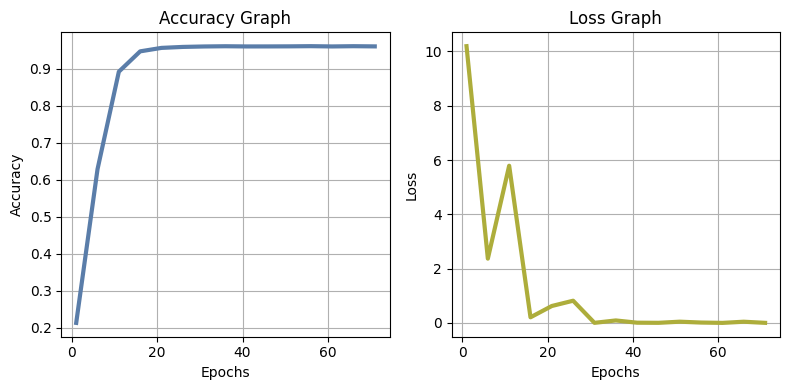

In [54]:
epoch_list = [i for i in range(1, epochs, 5)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

axes[0].plot(epoch_list, all_accuracies, color='#5a7da9', label='Accuracy', linewidth=3)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Graph')
axes[0].grid(True)


axes[1].plot(epoch_list, all_losses, color='#adad3b', label='Accuracy', linewidth=3)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Graph')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [52]:
accuracy = calculate_topk_accuracy(model, test_loader)
print(f'Test K-Accuracy: {accuracy * 100:.2f}%')

Test K-Accuracy: 19.71%


In [56]:
model_path = '.'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to my_bilstm_model.pth


In [57]:
class BiLSTM(nn.Module):
  def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
    super(BiLSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
    self.dropout = nn.Dropout(0.4)
    self.fc = nn.Linear(hidden_dim * 2, target_vocab_total_words)

  def forward(self, x):
    x = x.to(self.embedding.weight.device)
    embedded = self.embedding(x)
    lstm_out, _ = self.lstm(embedded)
    lstm_out = self.dropout(lstm_out)
    output = self.fc(torch.cat((lstm_out[:, -1, :hidden_dim], lstm_out[:, 0, hidden_dim:]), dim=1))
    return output

In [58]:
embedding_dim = 128
hidden_dim = 200
saved_model = BiLSTM(features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim)

In [59]:
model_path = 'my_bilstm_model.pth'
saved_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [61]:
def text_to_numerical_sequence_test(tokenized_text):
  token_list = []
  for token in tokenized_text:
    num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>']
    token_list.append(num_token)
  return token_list

In [65]:
def use_model(input_list, top_k=5):
  saved_model.eval()
  output_list = []
  for data in input_list:
    sentence = data[0]
    num_words = data[1]
    for i in range(num_words):
      output_of_model=[]
      tokenized_input_test = tokenizer(sentence)
      tokenized_sequence_input_test = text_to_numerical_sequence_test(tokenized_input_test)
      padded_tokenized_sequence_input_test = F.pad(torch.tensor(tokenized_sequence_input_test),
                                                   (longest_sequence_feature - len(tokenized_sequence_input_test), 0),
                                                   value=0)
      output_test_walking = model(padded_tokenized_sequence_input_test.unsqueeze(0))
      top_predictions = torch.topk(output_test_walking, top_k)
      for index in top_predictions.indices.squeeze():
        sentence_with_predictions = sentence + ' ' + target_vocab.lookup_tokens([index.item()])[0]
        output_list.append(sentence_with_predictions)

    sentence = output_list[-1]

  return output_list

In [66]:
input_test = [['Hi', 1], ['Hello', 1]]

In [67]:
outputs_model = use_model(input_test, 5)
outputs_model

['Hi how',
 'Hi there',
 'Hi can',
 'Hi sorry',
 'Hi what',
 'Hello there',
 'Hello how',
 'Hello i',
 'Hello deja',
 'Hello nice']